# Performance analysis of a uniform linear array

We compare the MSE of MUSIC with the CRB for a uniform linear array (ULA).

In [1]:
import numpy as np
import doatools.model as model
import doatools.estimation as estimation
import doatools.performance as perf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Work\repos\pydoatools\doatools\optim\l1lsq.py:9: UserWarning: Cannot import cvxpy. Some sparse recovery based estimators will not be usable.
  warnings.warn('Cannot import cvxpy. Some sparse recovery based estimators will not be usable.')


In [6]:
wavelength = 1.0 # normalized
d0 = wavelength / 2

# Create a 12-element ULA.
ula = model.UniformLinearArray(12, d0)
# Place 8 sources uniformly within (-pi/3, pi/4)
sources = model.FarField1DSourcePlacement(
    np.linspace(-np.pi/3, np.pi/4, 8)
)
# All sources share the same power.
power_source = 1 # Normalized
source_signal = model.ComplexStochasticSignal(sources.size, power_source)
# 200 snapshots.
n_snapshots = 200
# We use root-MUSIC.
estimator = estimation.RootMUSIC1D(wavelength)

We vary the SNR from -20 dB to 20 dB. Here the SNR is defined as:
\begin{equation}
    \mathrm{SNR} = 10\log_{10}\frac{\min_i p_i}{\sigma^2_{\mathrm{n}}},
\end{equation}
where $p_i$ is the power of the $i$-th source, and $\sigma^2_{\mathrm{n}}$ is the noise power.

In [7]:
snrs = np.linspace(-20, 10, 20)
# 300 Monte Carlo runs for each SNR
n_repeats = 300

mses = np.zeros((len(snrs),))
crbs_sto = np.zeros((len(snrs),))
crbs_det = np.zeros((len(snrs),))
crbs_stouc = np.zeros((len(snrs),))

for i, snr in enumerate(snrs):
    power_noise = power_source / (10**(snr / 10))
    noise_signal = model.ComplexStochasticSignal(ula.size, power_noise)
    # The squared errors and the deterministic CRB varies
    # for each run. We need to compute the average.
    cur_mse = 0.0
    cur_crb_det = 0.0
    for r in range(n_repeats):
        # Stochastic signal model.
        A = ula.steering_matrix(sources, wavelength)
        S = source_signal.emit(n_snapshots)
        N = noise_signal.emit(n_snapshots)
        Y = A @ S + N
        Rs = (S @ S.conj().T) / n_snapshots
        Ry = (Y @ Y.conj().T) / n_snapshots
        resolved, estimates = estimator.estimate(Ry, sources.size, d0)
        # In practice, you should check if `resolved` is true.
        # We skip the check here.
        cur_mse += np.mean((estimates.locations - sources.locations)**2)
        B_det = perf.ecov_music_1d(ula, sources, wavelength, Rs, power_noise,
                                   n_snapshots)
        cur_crb_det += np.mean(np.diag(B_det))
    # Update the results.
    B_sto,_ = perf.crb_sto_farfield_1d(ula, sources, wavelength, power_source,
                                     power_noise, n_snapshots)
    B_stouc,_ = perf.crb_stouc_farfield_1d(ula, sources, wavelength, power_source,
                                         power_noise, n_snapshots)
    mses[i] = cur_mse / n_repeats
    crbs_sto[i] = np.mean(np.diag(B_sto))
    crbs_det[i] = cur_crb_det / n_repeats
    crbs_stouc[i] = np.mean(np.diag(B_stouc))
    print('Completed SNR = {0:.2f} dB'.format(snr))

AttributeError: 'FarField2DSearchGrid' object has no attribute 'estimate'

We plot the results below.

* The MSE should approach the stochastic CRBs in high SNR regions.
* The stochastic CRB should be tighter than the deterministic CRB.
* With the additional assumption of uncorrelated sources, we expect a even lower CRB.
* All three CRBs should converge together as the SNR approaches infinity.

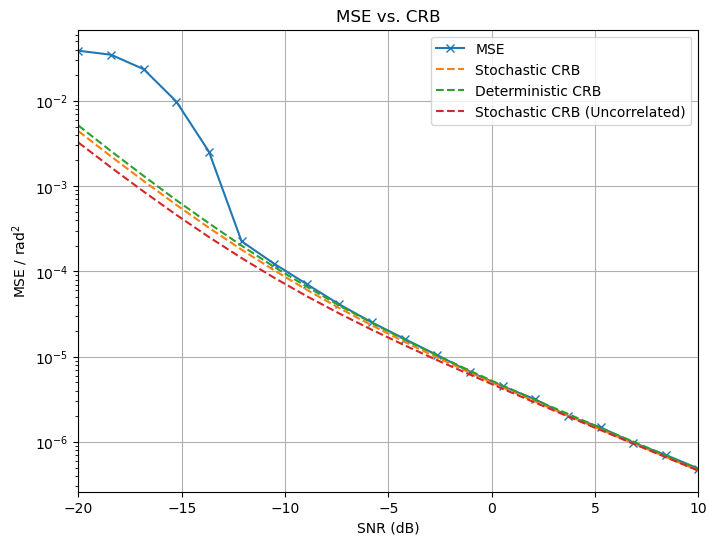

In [5]:
plt.figure(figsize=(8, 6))
plt.semilogy(
    snrs, mses, '-x',
    snrs, crbs_sto, '--',
    snrs, crbs_det, '--',
    snrs, crbs_stouc, '--'
)
plt.xlabel('SNR (dB)')
plt.ylabel(r'MSE / $\mathrm{rad}^2$')
plt.grid(True)
plt.legend(['MSE', 'Stochastic CRB', 'Deterministic CRB', 
           'Stochastic CRB (Uncorrelated)'])
plt.title('MSE vs. CRB')
plt.margins(x=0)
plt.show()